In [1]:
from pathlib import Path
import os
import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.optimize import curve_fit
from pydidas.core import Dataset
from pydidas.data_io import import_data
%matplotlib inline


import importlib
import sys

from dataclasses import dataclass
from scipy.optimize import curve_fit

from pydidas.core.constants import PROC_PLUGIN, PROC_PLUGIN_INTEGRATED
from pydidas.plugins import ProcPlugin


fname = '/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins/sin2chi_grouping.py'
spec = importlib.util.spec_from_file_location('sin2chi_grouping', fname)
sin2chi_grouping = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sin2chi_grouping)

fname = '/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins/stress_strain.py'
spec = importlib.util.spec_from_file_location('stress_strain', fname)
stress_strain = importlib.util.module_from_spec(spec)
spec.loader.exec_module(stress_strain)


# Check if the module object is created
if hasattr(sin2chi_grouping, '__file__'):
    print("Module was successfully loaded.")

# Inspect module attributes
print("Module attributes:", dir(sin2chi_grouping))

#We need to append the path to the sys.path to import the module
sys.path.append('/Users/lotzegud/pydidas/pydidas_plugins/proc_plugins')

from sin2chi_grouping import Labels, Units, Tolerance, Category, DictViaAttrs, DspacingSin2chiGrouping

from stress_strain import create_final_result_sin2chi_method

Module was successfully loaded.
Module attributes: ['Category', 'Dataset', 'Dict', 'DictViaAttrs', 'DspacingSin2chiGrouping', 'Enum', 'IntEnum', 'Labels', 'List', 'PROC_PLUGIN', 'PROC_PLUGIN_INTEGRATED', 'ProcPlugin', 'StrEnum', 'Tolerance', 'Tuple', 'Units', '__all__', '__author__', '__builtins__', '__cached__', '__copyright__', '__doc__', '__file__', '__license__', '__loader__', '__maintainer__', '__name__', '__package__', '__spec__', '__status__', 'connected_components', 'csr_matrix', 'np']


Ds1 shape  (3, 21, 36, 5)
(36, 5)
 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶
(36, 5)
36
19
 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶 🌶
input_shape (36, 5)
result_shape None
input_data None
_dict {'_chi_key': None, '_pos_key': None, '_pos_idx': None, '_s2c_labels': None, '_n_components': None}
_chi_key None
_pos_key None
_pos_idx None
_s2c_labels None
_n_components None


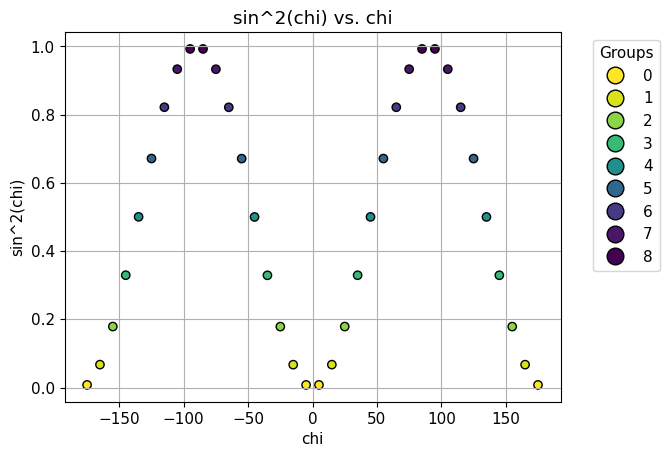

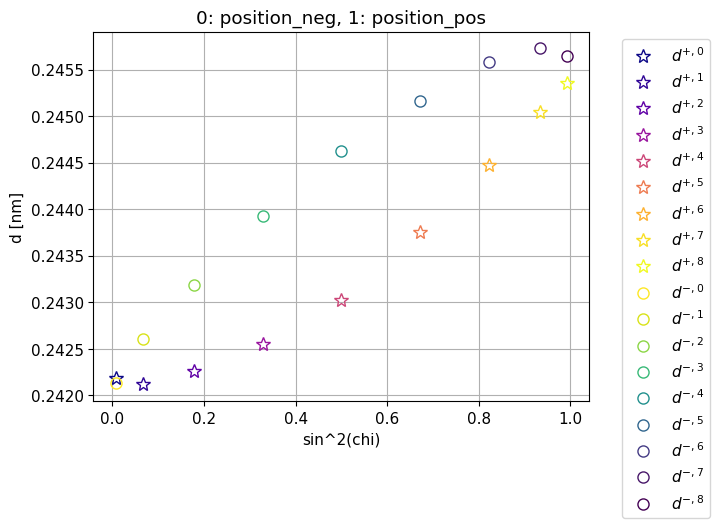

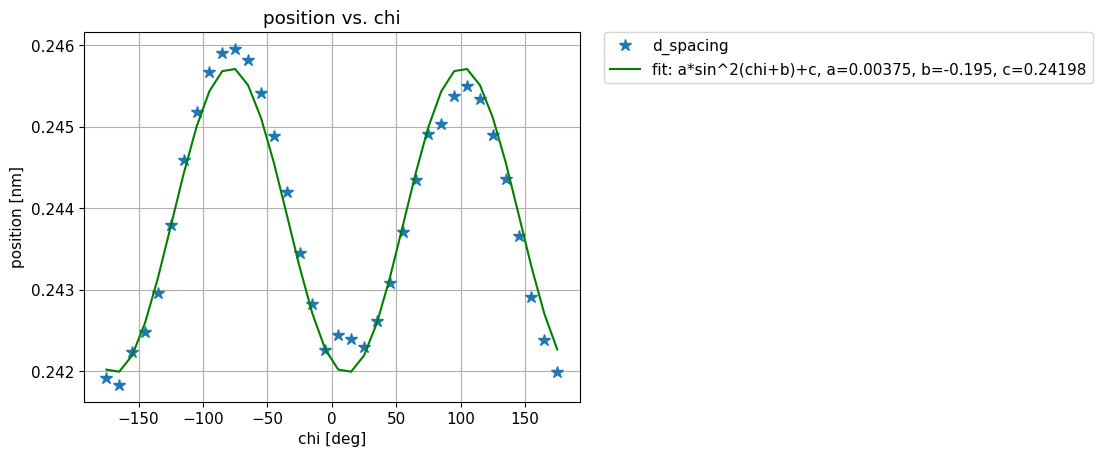

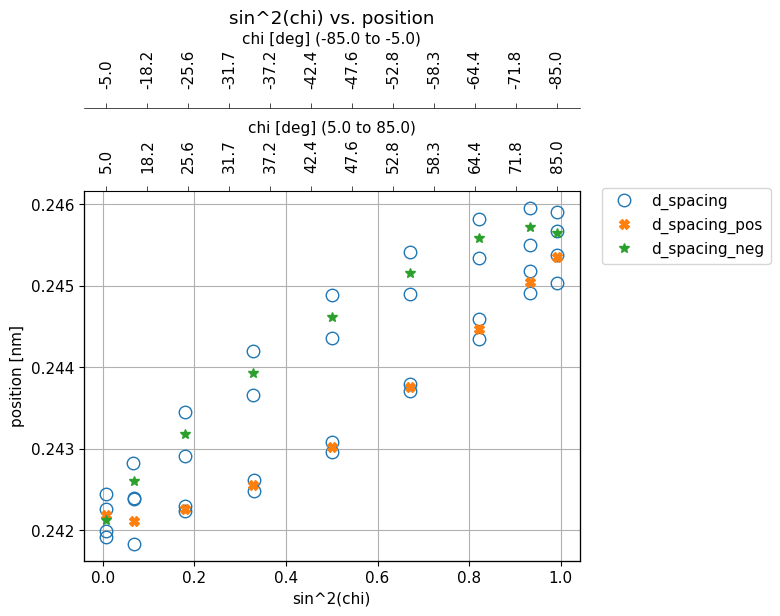

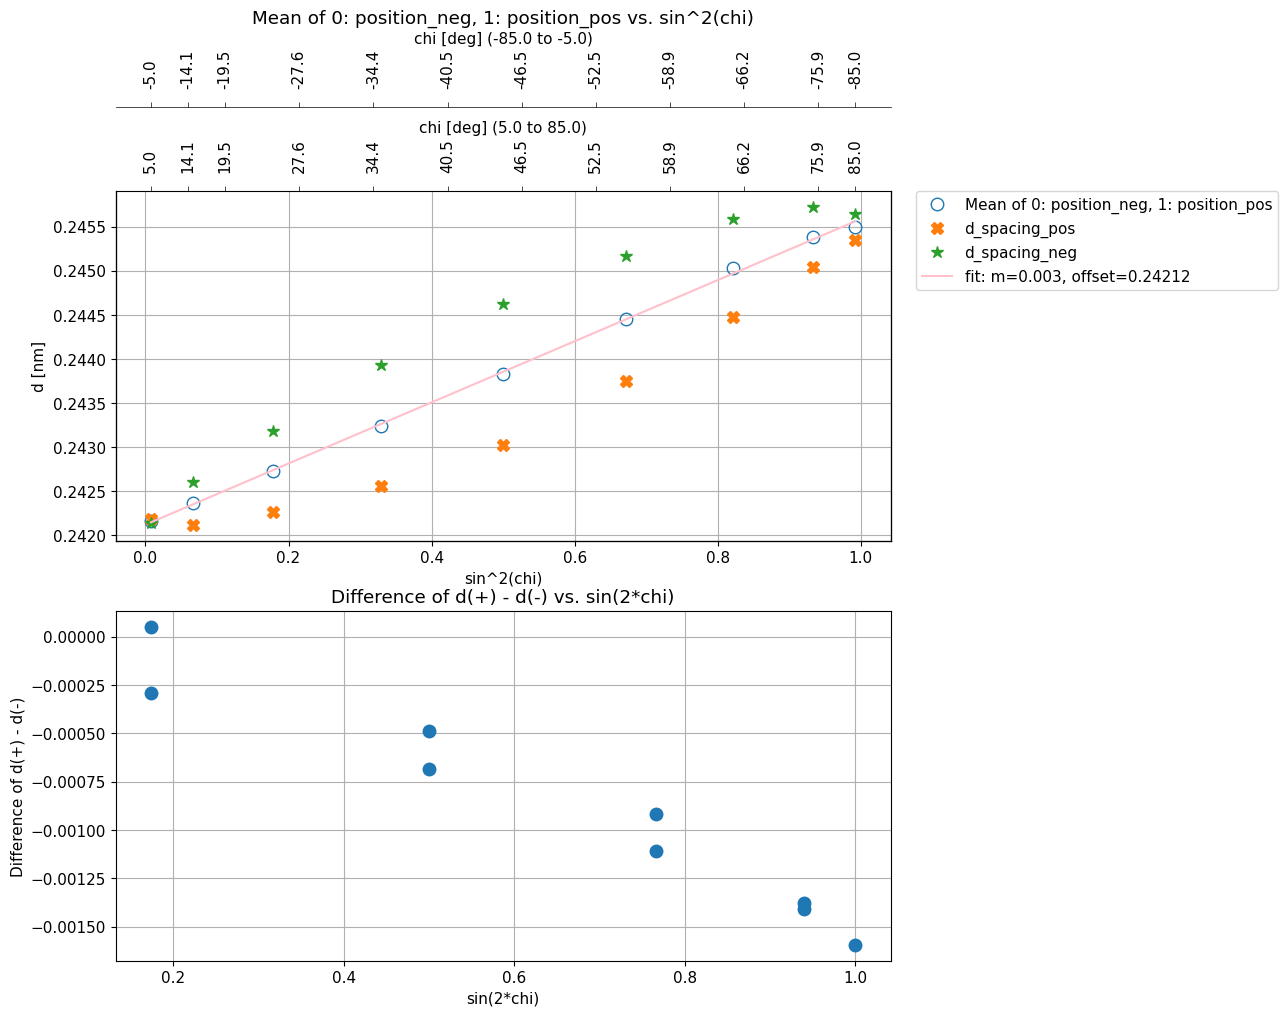

🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓🍓
d_spacing shape (36,)
s2c_labels [0 1 2 3 4 5 6 7 8 8 7 6 5 4 3 2 1 0 0 1 2 3 4 5 6 7 8 8 7 6 5 4 3 2 1 0]
Length of s2c_labels 36
Unique s2c_labels [0 1 2 3 4 5 6 7 8]
Length of unique s2c_labels 9
d_spacing_pos shape (9,)
d_spacing_neg shape (9,)
d_spacing_combined shape (2, 9)
d_spacing_avg shape (9,)
d_spacing_diff shape (9,)
🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒🍒
My shape: (36, 5)
arr shape (3, 9)
dummy_arr  [[0.24213326 0.24260821 0.24318507 0.24393073 0.24462088 0.24516153
  0.24558193 0.24572661 0.24564341        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan]
 [0.24218503 0.24211836 0.24226626 0.24255483 0.24302618 0.24375416
  0.24447224 0.24504359 0.24535283        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan]
 [0.24215914 0.24236329 0.24272567 0.24324278 0.24382353 0.24445784
  0.24502708 0.2453851  0.24549812        nan 

In [2]:
@dataclass
class Real_Dataset_Info:
    path: Path
    fname: str
    
    def fpath(self) -> Path:
        return self.path / Path(self.fname)
    
def chi_gen(chi_start, chi_stop, delta_chi):
    if chi_start >= chi_stop:
        raise ValueError('chi_start has to be smaller than chi_stop')
    return np.arange(chi_start, chi_stop, delta_chi)


def predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift):
    """ Calculate predefined metric based on name, applying spatial variation even if x is not provided. """
    # Handle spatial variation by introducing a default or random x if none is provided
    if x is None and spatial_var:
        x = np.random.uniform(0, 1)  #A random x between 0 and 5
    if metric_name == "position":
        return 0.2832*np.sin(np.deg2rad(chi+phase_shift))**2 + d0 + (0.01 * x if spatial_var else 0)
    if metric_name == "area":
        return np.random.uniform(6, 37, size=len(chi)) + 0.1 * y
    if metric_name == "FWHM":
        return np.random.uniform(0.35, 0.75, size=len(chi))
    if metric_name == "background at peak":
        return np.random.uniform(2.3, 5.3, size=len(chi))
    if metric_name == "total count intensity":
        return np.random.uniform(80, 800, size=len(chi))
    return np.random.uniform(1.5708, 3.141, size=len(chi))  # Fallback for unknown metrics

def plot_sin2chi(chi):
    fig, ax = plt.subplots()
    ax.plot(chi, np.sin(np.deg2rad(chi))**2, linestyle='None', marker='o')
    ax.set_xlabel('chi [deg]')
    ax.set_ylabel('sin^2(chi)')
    ax.set_title('sin^2(chi) vs chi')
    ax.grid()
    plt.show()

def generate_spatial_fit_res(y_range, x_range=None, chi_start=-175, chi_stop=180, delta_chi=10, fit_labels=None, spatial_var=True, phase_shift=0):
    '''
    chi [degree]
    phase_shift [degree]
    '''
    
    if fit_labels is None:
        fit_labels = '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(k.split(':')[0].strip()): k.split(':')[1].strip() for k in fit_labels.replace(', ', ';').split(';')}

    chi = chi_gen(chi_start, chi_stop, delta_chi)
    d0 = 25  # in nm

    # Determine the dimensions based on x_range
    if x_range is not None:
        result_array = np.empty((len(y_range), len(x_range), len(chi), len(fit_labels_dict)))
    else:
        result_array = np.empty((len(y_range), len(chi), len(fit_labels_dict)))
        x_range = [None]  # Simulate the absence of x values

    # Perform calculations for each y and x, and across all metrics
    for j, y in enumerate(y_range):
        for i, x in enumerate(x_range):
            fit_results = []
            for idx in sorted(fit_labels_dict.keys()):
                metric_name = fit_labels_dict[idx]
                result = predefined_metric_calculation(metric_name, chi, x, y, d0, spatial_var, phase_shift)
                fit_results.append(result)

            fit_results = np.array(fit_results)
            # Adjust how results are stored based on the presence of x_range
            # Debug print statements
            #print(f"fit_results.T.shape: {fit_results.T.shape}, j: {j}, i: {i}")
            #print('x_range:', x_range)
            if x is not None:
                result_array[j, i, :, :] = fit_results.T
            else:
                result_array[j, :, :] = fit_results.T  # Ensure dimensionality matches expected (len(chi), len(fit_labels_dict))

    return result_array

def adding_noise_d_spacing(d_spacing, scale=0.03, mean_value=1, seed=10):
    '''
    ds: Dataset, expecting in first column d-spacing values.
    Noise follows a Laplace distribution
    mean_value, scale: Mean_value and scale parameter of Laplace distribution
    Seed: radnom seed
    
    '''
    ds = d_spacing.copy()
    #Introducing seed and random noise for d_spacing
    # Define the scale parameter for the Laplace distribution
    # Generate Laplace noise centered around the mean value
    d_spacing_noise = np.random.default_rng(seed=seed).laplace(mean_value, scale, size=d_spacing.array.shape[0])
 
    d_spacing_with_noise = d_spacing.array[:,0] + d_spacing_noise
    #update array in ds
    ds.array[:,0] = d_spacing_with_noise
    return ds
  


def plot_d_spacing_vs_chi_1d(ds, chi, scan_axis):
    
    print('ds.shape:', ds.shape)
    
    chi_key, (pos_key, pos_idx)  = chi_pos_verification(ds)
    
    fig, ax = plt.subplots()
    
    for pos in ds.axis_ranges[scan_axis]:
        # Extract d_spacing for the specific position
        d_spacing = ds[pos, :, ]
   

def plot_d_spacing_vs_chi_2d_2d(ds, chi, positions):
    """
    Plots d_spacing vs chi for specified (x, y) positions in the result array using Matplotlib's OOP interface.

    Parameters:
        ds (Dataset): The 4D array containing measurement data.
        chi (numpy.ndarray): The array of chi values.
        positions (list of tuples): A list of (x_index, y_index) tuples specifying the positions to plot.
    """

    print('ds.shape:', ds.shape)
    
    fig, ax = plt.subplots()
    for (x_index, y_index) in positions:
        # Extract d_spacing for the specific position
        d_spacing = ds.array[x_index, y_index, :, 0]  # d_spacing is the first property in the last dimension
        
        # Plotting using the axes object
        ax.plot(chi, d_spacing, label=f'(x={x_index}, y={y_index})', marker='o', linestyle='--')
    
    ax.set_xlabel('chi [deg]')
    ax.set_ylabel('d_spacing')
    ax.set_title('d_spacing vs. chi for various x,y')
    ax.grid(True)
    
    ax.legend()
    plt.show()
    
   
def split_fit_labels(input_string):

    # Split the string into key:value pairs
    pairs = input_string.split(';')

    # Initialize an empty dictionary to hold the key:value pairs
    result_dict = {}

    # Loop through each pair, split it into key and value, and add them to the dictionary
    for pair in pairs:
        # Strip any extra whitespace
        pair = pair.strip()
        # Split the pair into key and value
        if pair:
            key, value = pair.split(': ')
            # Add the key:value to the dictionary
            result_dict[int(key)] = value


    return result_dict



def plot_d_spacing_grouping(d_spacing_combined, s2c_labels):
        
    sin2chi = d_spacing_combined.axis_ranges[1]
    d_minus = d_spacing_combined.array[0]
    d_plus = d_spacing_combined.array[1]
        
    # Number of categories
    num_categories = len(s2c_labels)
    
    # Define the colormap
    cmap1= plt.get_cmap('viridis_r')  # Using reversed Viridis colormap
    cmap2=plt.get_cmap('plasma')

    # Normalize sin2chi values to the range [0, 1]
    norm = matplotlib.colors.Normalize(vmin=min(sin2chi), vmax=max(sin2chi))

    # Map normalized values to colormap
    colors1 = cmap1(norm(sin2chi))
    colors2= cmap2(norm(sin2chi))
    
    
    fig, ax = plt.subplots()
    # Plot d_plus values with the mapped colormap
    for x, y, color, category in zip(sin2chi, d_plus, colors2, s2c_labels):
        ax.plot(x, y, label=f"$d^{{+, {category}}}$", marker='*', markersize=10, linestyle='None',  markeredgecolor=color, markerfacecolor='None')

    # Plot d_minus values with the mapped colormap
    for x, y, color, category in zip(sin2chi, d_minus, colors1, s2c_labels):
        ax.plot(x, y, label=f"$d^{{-, {category}}}$", markersize=8, linestyle='None', marker='o', markeredgecolor=color, markerfacecolor='None')


    # Remove duplicate labels in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend position

    # Set labels and title
    ax.set_xlabel(f'{d_spacing_combined.axis_labels[1]}')
    ax.set_ylabel(f'd [{d_spacing_combined.data_unit}]')
    ax.set_title(f'{d_spacing_combined.data_label}')
    ax.grid()

    plt.show()

def plot_chi_vs_sin2chi(chi: np.ndarray, s2c_labels, n_components, tolerance: float = 1e-4):
    sin2chi = np.sin(np.deg2rad(chi)) ** 2

    # Get grouping based on sin^2(chi) values
    num_groups, group_labels = (n_components, s2c_labels)
    
    # Define colormap
    cmap = plt.get_cmap('viridis_r')  # Reversed Viridis colormap
     
    # Map group labels to colors
    norm = matplotlib.colors.Normalize(vmin=min(sin2chi), vmax=max(sin2chi))
    colors = cmap(norm(sin2chi))
    
    fig, ax = plt.subplots()
    
    # Plot chi vs sin^2(chi) with colours
    scatter = ax.scatter(chi, sin2chi, c=colors, marker='o', edgecolor='k')
    
    # Create a legend based on group labels
    handles = [plt.Line2D([0], [0], marker='o', color='k', markerfacecolor=colors[i], markersize=12, linestyle='None', label=f'{i}') for i in range(num_groups)]
    ax.legend(handles=handles, title='Groups', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set labels and title
    ax.set_xlabel('chi')
    ax.set_ylabel('sin^2(chi)')
    ax.set_title('sin^2(chi) vs. chi')
    ax.grid()
    
    plt.show()



def plot_d_spacing_vs_sin2chi_fit(chi, ds, d_spacing, units, pos_key, pos_idx, chi_key):
    
    d_spacing_low=np.min(d_spacing.array)
    popt, pcov = curve_fit(sin2_fit, chi, d_spacing,maxfev=100000, sigma=0.001*np.ones(chi.shape), absolute_sigma=False, bounds=((0, -2, d_spacing_low-0.5),(1, 2, d_spacing_low+0.5)))
    a_fit=popt[0]
    b_fit=popt[1]
    c_fit=popt[2]
    axis_labels_dict = split_fit_labels(ds.axis_labels[pos_key])
    fig, ax = plt.subplots()
    ax.plot(chi, d_spacing, linestyle='None', marker='*', label='d_spacing', markersize=9)
    ax.plot(chi, sim_sin2(chi, a_fit, b_fit, c_fit), color='green', label=f'fit: a*sin^2(chi+b)+c, a={a_fit:.5f}, b={b_fit:.3f}, c={c_fit:.5f}')
    ax.set_ylabel(f'{axis_labels_dict[pos_idx]} [{units[pos_idx][1]}]')
    ax.set_xlabel(f'{ds.axis_labels[chi_key]} [{ds.axis_units[chi_key]}]')    
    ax.set_title(f'{axis_labels_dict[pos_idx]} vs. {ds.axis_labels[chi_key]}')
    ax.grid()
    ax.legend(loc='upper right', bbox_to_anchor=(2.05, 1.02))
    plt.show()


    
def plot_d_spacing_pos_neg(chi, ds, d_spacing, d_spacing_pos, d_spacing_neg, units, pos_idx, pos_key):
    
    axis_labels_dict = split_fit_labels(ds.axis_labels[pos_key])
    
    
    fig, ax = plt.subplots()
    ax.plot(np.sin(np.deg2rad(chi))**2, d_spacing, linestyle='None', marker='o', label='d_spacing', markerfacecolor='None', markersize=9)
    ax.plot(d_spacing_pos.axis_ranges[0], d_spacing_pos.array, linestyle='None', marker='X', label='d_spacing_pos', markersize=7)
    ax.plot(d_spacing_neg.axis_ranges[0], d_spacing_neg.array, linestyle='None', marker='*', label='d_spacing_neg', markersize=7)
    ax.set_ylabel(f'{axis_labels_dict[pos_idx]} [{units[pos_idx][1]}]')
    ax.set_xlabel(f'{d_spacing_pos.axis_labels[0]}')
    ax.set_title(f'{d_spacing_pos.axis_labels[0]} vs. {axis_labels_dict[pos_idx]}')
    
    add_chi_axes(ax, chi, fig)
    ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.03))
    ax.grid()
    plt.show()
    
    
def plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, d_spacing_diff, chi):
    
    mask = ~np.isnan(d_spacing_avg.array)
    x_data_filtered = d_spacing_avg.axis_ranges[0][mask]
    y_data_filtered = d_spacing_avg.array[mask]
    
    popt_reg_fit, pcov_reg_fit = curve_fit(regression_line_fit, x_data_filtered, y_data_filtered, maxfev=100000, sigma=0.001*np.ones(y_data_filtered.shape), absolute_sigma=False)    
    m_fit=popt_reg_fit[0]
    offset_fit=popt_reg_fit[1]
       
    
    
    import matplotlib.gridspec as gridspec
    # Create a GridSpec with explicit height ratios
    fig = plt.figure(figsize=(10, 10))  # Adjust figure size as needed
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 1], hspace=0.2)  # Increase hspace for more vertical space

    # Create the subplots using ax[0] and ax[1]
    ax = [None, None]
    ax[0] = fig.add_subplot(gs[0])
    ax[1] = fig.add_subplot(gs[1])
    
    ax[0].plot(d_spacing_avg.axis_ranges[0],  d_spacing_avg.array, linestyle='None', marker='o', label=f'{d_spacing_avg.data_label}', markerfacecolor='None', markersize=9)
    ax[0].plot(d_spacing_combined.axis_ranges[1], d_spacing_combined.array[1,:], linestyle='None', marker='X', label='d_spacing_pos', markersize=8)
    ax[0].plot(d_spacing_combined.axis_ranges[1],  d_spacing_combined.array[0,:], linestyle='None', marker='*', label='d_spacing_neg', markersize=9)
    ax[0].plot(d_spacing_avg.axis_ranges[0], sim_regression_line(d_spacing_avg.axis_ranges[0], m_fit, offset_fit), color='pink', label=f'fit: m={m_fit:.3f}, offset={offset_fit:.5f}')
    ax[0].set_ylabel(f'd [{d_spacing_avg.data_unit}]')
    ax[0].set_xlabel(d_spacing_avg.axis_labels[0])
    ax[0].set_title(f'{d_spacing_avg.data_label} vs. {d_spacing_avg.axis_labels[0]}') #'sin^2(chi) vs d_spacing
    #interval = 4
    #x_index = np.arange(0, len(chi), interval)
    #ax2top=ax[0].twiny()
    #ax2top.set_xlim(ax[0].get_xlim())
    #formatted_labels = [f'{val:.2f}' for val in chi[x_index]]
    #ax2top.set_xticks(x_index)
    #ax2top.set_xticklabels(formatted_labels)
    #ax2top.set_xlabel('chi [deg]')
    ax[0].legend(loc='upper right', bbox_to_anchor=(1.51, 1.02))
    
    add_chi_axes(ax[0], chi, fig)
    
    ax[0].grid()
    
    ax[1].plot(d_spacing_diff.axis_ranges[0], d_spacing_diff.array, linestyle='None', marker='o', label=d_spacing_diff.data_label, markersize=9)
    ax[1].set_title(f'{d_spacing_diff.data_label} vs. {d_spacing_diff.axis_labels[0]}')
    ax[1].set_xlabel(f'{d_spacing_diff.axis_labels[0]}')
    ax[1].set_ylabel(f'{d_spacing_diff.data_label}')
    ax[1].grid()
    # Adjust the space between the subplots
    fig.subplots_adjust(hspace=0.5)  # Adjust the vertical space    
    plt.show() 
   
def split_fit_labels(input_string):

    # Split the string into key:value pairs
    pairs = input_string.split(';')

    # Initialize an empty dictionary to hold the key:value pairs
    result_dict = {}

    # Loop through each pair, split it into key and value, and add them to the dictionary
    for pair in pairs:
        # Strip any extra whitespace
        pair = pair.strip()
        # Split the pair into key and value
        if pair:
            key, value = pair.split(': ')
            # Add the key:value to the dictionary
            result_dict[int(key)] = value


    return result_dict

  
def sin2_fit(chi, a, b,c ):
    return a*np.sin(np.deg2rad(chi)+b)**2+c  

def sim_sin2(chi, a, b,c):
    return a*np.sin(np.deg2rad(chi)+b)**2+c

def regression_line_fit(s2c, m, offset):
    return m*s2c + offset

def sim_regression_line(s2c, m, offset):
    return m*s2c + offset


def unique_labels(ticks, function, close_value_threshold=5):
    """Generate unique labels for the ticks using the provided function, avoiding close values."""
    labels = [f'{function(tick):.1f}' for tick in ticks]
    unique_ticks, unique_labels = [], []
    seen = set()

    for tick, label in zip(ticks, labels):
        float_label = float(label)
        # Avoid adding labels that are too close to any already seen
        if not any(abs(float_label - float(s)) < close_value_threshold for s in seen):
            unique_ticks.append(tick)
            unique_labels.append(label)
            seen.add(float_label)
    
    return unique_ticks, unique_labels

def add_chi_axes(ax, chi, fig):
    """
    Add two top x-axes to the given axes: one for positive chi and one for negative chi.
    Dynamically adjust the number of labels based on the figure width and avoid label overlap.
    
    Parameters:
        ax (matplotlib.axes.Axes): The axes to which the top x-axes will be added.
        chi (np.ndarray): The chi values in degrees.
        fig (matplotlib.figure.Figure): The figure containing the axes.
    """
    
    # Calculate sin^2(chi)
    sin2_chi = np.sin(np.deg2rad(chi))**2
    
    # Calculate the number of labels to display based on figure width
    fig_width = fig.get_size_inches()[0]  # Width of the figure in inches
    num_labels = max(5, int(fig_width * 2))  # Adjust this factor as needed

    # Calculate the corresponding chi values from sin^2(chi)
    chi_positive = np.rad2deg(np.arcsin(np.sqrt(sin2_chi)))
    chi_negative = np.rad2deg(np.arcsin(-np.sqrt(sin2_chi)))

    # Calculate ticks and labels for chi_positive
    ticks_pos = np.linspace(sin2_chi.min(), sin2_chi.max(), num_labels)
    ticks_pos = np.unique(np.concatenate(([sin2_chi[0]], ticks_pos, [sin2_chi[-1]])))
    unique_ticks_pos, unique_labels_pos = unique_labels(ticks_pos, lambda t: np.rad2deg(np.arcsin(np.sqrt(t))))
    
    # Create top x-axis for chi_positive
    ax2top_pos = ax.twiny()
    ax2top_pos.set_xlim(ax.get_xlim())
    
    # Position the second top x-axis slightly outward
    ax2top_pos.spines['top'].set_position(('outward', 0))  # Adjust this value for proper spacing
    ax2top_pos.spines['top'].set_linewidth(0.5)  # Adjust line width if needed

    # Set the ticks and labels for chi_positive
    ax2top_pos.set_xticks(unique_ticks_pos)
    ax2top_pos.set_xticklabels(unique_labels_pos)

    # Dynamic label for chi_positive
    chi_pos_min = np.min(chi_positive)
    chi_pos_max = np.max(chi_positive)
    ax2top_pos.set_xlabel(f'chi [deg] ({chi_pos_min:.1f} to {chi_pos_max:.1f})')

    # Calculate ticks and labels for chi_negative
    ticks_neg = np.linspace(sin2_chi.min(), sin2_chi.max(), num_labels)
    ticks_neg = np.unique(np.concatenate(([sin2_chi[0]], ticks_neg, [sin2_chi[-1]])))
    unique_ticks_neg, unique_labels_neg = unique_labels(ticks_neg, lambda t: np.rad2deg(-np.arcsin(np.sqrt(t))))
    
    # Create another top x-axis for chi_negative
    ax2top_neg = ax.twiny()
    ax2top_neg.set_xlim(ax.get_xlim())
    
    # Move the second top axis further outward
    ax2top_neg.spines['top'].set_position(('outward', 60))  # Further outward than ax2top_pos
    ax2top_neg.spines['top'].set_linewidth(0.5)  # Adjust line width if needed

    # Set the ticks and labels for chi_negative
    ax2top_neg.set_xticks(unique_ticks_neg)
    ax2top_neg.set_xticklabels(unique_labels_neg)

    # Dynamic label for chi_negative
    chi_neg_min = np.min(chi_negative)
    chi_neg_max = np.max(chi_negative)
    ax2top_neg.set_xlabel(f'chi [deg] ({chi_neg_min:.1f} to {chi_neg_max:.1f})')

    # Adjust label rotation and alignment to prevent overlap
    for label in ax2top_pos.get_xticklabels():
        label.set_rotation(90)  # Rotate labels for readability
        label.set_horizontalalignment('center')  # Center-align labels
        label.set_verticalalignment('bottom')  # Bottom-align labels

    for label in ax2top_neg.get_xticklabels():
        label.set_rotation(90)  # Rotate labels for readability
        label.set_horizontalalignment('center')  # Center-align labels
        label.set_verticalalignment('bottom')  # Bottom-align labels

    # Adjust spacing between labels and axis
    ax2top_pos.xaxis.set_tick_params(width=0.5, pad=10)  # Increase padding
    ax2top_neg.xaxis.set_tick_params(width=0.5, pad=10)  # Increase padding


    
def create_dummy_dataset(delta_chi, chi_start, chi_stop, phase_shift, spatial_var=False):
       
    chi=chi_gen(chi_start, chi_stop, delta_chi)
    print('Chi\n', chi)
    
    plot_sin2chi(chi)
   
    #x, y in um
    y = np.arange(2, 8)
    x = np.arange(0, 5)

    #labels
    fit_labels= '0: position; 1: area; 2: FWHM; 3: background at peak; 4: total count intensity'
    fit_labels_dict = {int(item.split(":")[0].strip()): item.split(":")[1].strip() for item in fit_labels.split(";")}
    num_labels = len(fit_labels_dict)
    
    #make up data label 
    data_labels= 'position / nm; area / (cts * nm); FWHM / nm;background at peak / cts; total count intensity / cts'
    
    
    #creation of Pydidas Dataset
    axis_labels= ['y', 'x', 'chi', fit_labels]
    axis_ranges = {0: y, 1:x, 2: chi , 3: np.arange(num_labels)} 
    axis_units= ['um', 'um', 'deg', '']    
   
    result_array= generate_spatial_fit_res(y, x, chi_start,chi_stop, delta_chi, fit_labels , spatial_var=spatial_var, phase_shift=phase_shift)
    
    print('Result array shape\n', result_array.shape)
    ds = Dataset(result_array,  axis_labels=axis_labels, axis_units=axis_units,axis_ranges=axis_ranges, data_label=data_labels)
         
    return (chi, ds)


def main():
    
    #chi, ds = create_dummy_dataset(delta_chi=10, chi_start=-180, chi_stop=180, phase_shift=70, spatial_var=False)
    
    ds1= import_data('/Users/lotzegud/pydidas_training/TiN_dummy/node_04_peak_2.h5')
    print('Ds1 shape ' ,ds1.shape)    
    
    x_idx=2
    y_idx=4
     
    
            
    plugin=DspacingSin2chiGrouping(stress_strain_config=DictViaAttrs(dict()))
    import pickle
    print(pickle.loads(pickle.dumps(plugin)))
  
    plugin.input_shape = (ds1.shape[2], ds1.shape[-1])
    print(plugin.input_shape)

    plugin.pre_execute()
    for key, value in plugin.config._dict.items():
        print(key, value)
    
    
    """   
    print(40*"\N{popcorn}")
    print(ds)
    print(40*"\N{popcorn}")
    axis_labels = ds.axis_labels
    print('Axis labels\n', axis_labels)
    print('Shape of dataset\n', ds.shape)
    print('Type ds\n', type(ds))
    print('Data label: ', ds.data_label)
    print(40*"\N{popcorn}")
    
    # slice Dataset based on location
    ds1 = ds[x_idx, y_idx]
    #Introducing seed and random noise for d_spacing
    ds1 = adding_noise_d_spacing(ds1, scale=0.01, mean_value=1, seed=10)
    """
    
    ds1 = ds1[x_idx, y_idx]
    
    chi, d_spacing = plugin._ds_slicing(ds1) 
    d_spacing_pos, d_spacing_neg=plugin._group_d_spacing_by_chi(d_spacing, chi)
    d_spacing_combined = plugin._combine_sort_d_spacing_pos_neg(d_spacing_pos, d_spacing_neg)
    d_spacing_avg, d_spacing_diff = plugin._pre_regression_calculation(d_spacing_combined) 
    
    plot_chi_vs_sin2chi(chi, s2c_labels=plugin.config._s2c_labels, n_components=plugin.config._n_components, tolerance=1e-4)
    
    
    plot_d_spacing_grouping(d_spacing_combined, s2c_labels=plugin.config._s2c_labels)
    
    plot_d_spacing_vs_sin2chi_fit(chi, ds1, d_spacing, units=plugin._extract_units(ds1), pos_key=plugin.config._pos_key, pos_idx=plugin.config._pos_idx, 
                                  chi_key=plugin.config._chi_key)
    
    
    plot_d_spacing_pos_neg(chi, ds1, d_spacing, d_spacing_pos, d_spacing_neg, units=plugin._extract_units(ds1), pos_idx=plugin.config._pos_idx, pos_key=plugin.config._pos_key)
    
    plot_pre_regression_calculation_res(d_spacing_combined, d_spacing_avg, d_spacing_diff, chi)
    
    print(30*"\N{strawberry}")
    print('d_spacing shape', d_spacing.shape)
    print('s2c_labels', plugin.config._s2c_labels)
    print('Length of s2c_labels', len(plugin.config._s2c_labels))
    print('Unique s2c_labels', np.unique(plugin.config._s2c_labels))
    print('Length of unique s2c_labels', len(np.unique(plugin.config._s2c_labels)))
    print('d_spacing_pos shape', d_spacing_pos.shape)
    print('d_spacing_neg shape', d_spacing_neg.shape)
    print('d_spacing_combined shape', d_spacing_combined.shape)
    print('d_spacing_avg shape', d_spacing_avg.shape)
    print('d_spacing_diff shape', d_spacing_diff.shape)
    
    print(40*"\N{Cherries}")
    
    
    #d_output_sin2chi_method= create_final_result_sin2chi_method(d_spacing_combined)
    d_output_sin2chi_method= plugin._create_final_result_sin2chi_method(d_spacing_combined)
   
  
    print(40*"\N{Aubergine}")
    print(d_output_sin2chi_method)
    print(d_output_sin2chi_method.shape, chi.shape)
    
    for key, value in d_output_sin2chi_method.axis_ranges.items():
        print('Pustekuchen')
        print(key, value)

if __name__ == "__main__":
    main()

In [3]:
arr= np.array([[1, 2, 3, 4], [5, 6, 7, 8], [3, 4, 5, 6]])

print(arr, arr.shape, arr.ndim)


d_spacing_combined = Dataset(
    np.array([[1, 2, 3, 4], [5, 6, 7, 8]], dtype=float), 
    axis_ranges={0: [0, 1], 1: [0, 1, 2, 3]}, 
    axis_labels={0: '0: d-, 1: d+', 1: Labels.SIN2CHI.value}, 
    data_unit='nm', 
    data_label='0: position_neg, 1: position_pos'
)

d_spacing_combined.array[0,0]= np.nan
d_spacing_combined.array[1,1]= np.nan

print(d_spacing_combined.array)

d_spacing_result = Dataset(
    np.array([[1, 2, 3, 4], [5, 6, 7, 8], [3, 4, 5, 6]]),
    axis_ranges={0: [0, 1, 2], 1: [0, 1, 2, 3]}, 
    axis_labels={0: '0: d-, 1: d+, 2: d_mean', 1: Labels.SIN2CHI},
    data_unit='nm', 
    data_label='d_spacing'
)


res1=create_final_result_sin2chi_method(d_spacing_combined)
print(res1)


[[1 2 3 4]
 [5 6 7 8]
 [3 4 5 6]] (3, 4) 2
[[nan  2.  3.  4.]
 [ 5. nan  7.  8.]]
Dataset(
axis_labels: {
    0: '0: d-, 1: d+, 2: d_mean'
    1: Labels.SIN2CHI('sin^2(chi)')},
axis_ranges: {
    0: array([0, 1, 2])
    1: array([0, 1, 2, 3])},
axis_units: {
    0: ''
    1: ''},
metadata: {},
data_unit: nm,
data_label: d_spacing,
array([[nan,  2.,  3.,  4.],
       [ 5., nan,  7.,  8.],
       [nan, nan,  5.,  6.]])
)


: 